# Wasserstein GAN

Brief introduction to Wasserstein GAN or WGANs. This notebook is organized as follows:

1. **Research Paper**
* **Background**
* **Definition**
* **Training WGAN with MNIST dataset, Keras and TensorFlow**


## 1. Research Paper

* [Wasserstein GAN](https://arxiv.org/pdf/1701.07875.pdf)

## 2. Background

Brief definition of some concepts, such as Wasserstein distance.

### Wasserstein distance

The Wasserstein distance is the cost of the cheapest transport plan or the minimum cost of transporting mass in converting the data distribution $q$ to the data distribution $p$. 

### GANs

**Generative adversarial nets** consists of two models: a generative model $G$ that captures the data distribution, and a discriminative model $D$ that estimates the probability that a sample came from the training data rather than $G$.

The generator distribution $p_g$ over data data $x$, the generator builds a mapping function from a prior noise distribution $p_z(z)$ to data space as $G(z;\theta_g)$.

The discriminator, $D(x;\theta_d)$, outputs a single scalar representing the probability that $x$ came form training data rather than $p_g$.

The **value function** $V(G,D)$:

$$ \underset{G}{min} \: \underset{D}{max} \; V_{GAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$

## 3. Definition

Wasserstein GAN (WGAN) proposes a new cost function using Wasserstein distance that has a smoother gradient everywhere. This model is proposed to measure the difference between the data distributions of real and generated images.

This network is very similar to the discriminator **$D$**, just without the sigmoid function and outputs a scalar score rather than a probability.

The discriminator **$D$** is rename to **Critic** to reflect its new role. 

### Network Design

<img src="../../img/network_design_dcgan.png" width="600"> 


### Cost Funcion

| Model | Discriminator/Critic | Generator             |
|:-----:|:--------------------:|:---------------------:|
| **GAN**   |  $$ \nabla_{\theta_{d}}\frac{1}{m}\sum_{i=1}^{m} [log(D(x^{(i)})) + log(1-D(G(z^{(i)})))]$$ | $$ \nabla_{\theta_{g}}\frac{1}{m}\sum_{i=1}^{m} -log(D(G(z^{(i)})))$$|
| **WGAN**  |$$ \nabla_{w}\frac{1}{m}\sum_{i=1}^{m} [f(x^{(i)}) - f(G(z^{(i)}))]$$ | $$ \nabla_{\theta_{g}}\frac{1}{m}\sum_{i=1}^{m} -f(G(z^{(i)}))$$|

* **Wasserstein objective:**

```
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)
```    
* **Critic training:**

1. Maximize $\frac{1}{m}\sum_{i=1}^{m} f(x^{(i)})$
* Minimize $\frac{1}{m}\sum_{i=1}^{m} f(G(z^{(i)}))$
* Weight clipping:

```
for l in critic.layers:
    weights = l.get_weights()
    weights = [np.clip(w, -clip_value, clip_value) for w in weights]
    l.set_weights(weights)
```

* **Generator training:**

1. Maximize $\frac{1}{m}\sum_{i=1}^{m} f(G(z^{(i)}))$

## 3. Training WGANs with MNIST dataset,  Keras and TensorFlow

* **Data**
    * Rescale the MNIST images to be between -1 and 1.
    
* **Generator**
    * Use the **inverse of convolution**, called transposed convolution.
    * **ReLU activation** and **BatchNormalization**.
    * The input to the generator is the **normal distribution** $z$ or latent sample (100 values).
    * The last activation is **tanh**.
    
* **Discriminator**
    * **Convolutional neural network**  and **LeakyReLU activation**.
    * **No activation** in the last layer
    
* **Loss**
    * wasserstein_loss

* **Optimizer**
    * RMSprop(lr=0.00005)

* batch_size = 64
* epochs = 100

### 1. Load data

#### Load libraries

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, ReLU, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.optimizers import RMSprop
from keras import initializers
from keras import backend as K

Using TensorFlow backend.


#### Getting the data

In [3]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#### Explore visual data

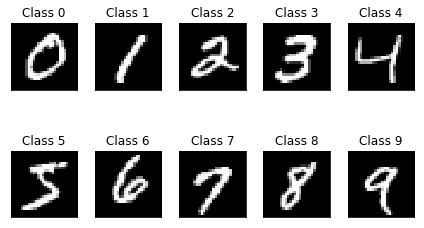

In [4]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

#### Reshaping and normalizing the inputs

In [5]:
print('X_train.shape', X_train.shape)

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

print('X_train reshape:', X_train.shape)

X_train.shape (60000, 28, 28)
X_train reshape: (60000, 28, 28, 1)


### 2. Define model

#### Generator


In [6]:
# latent space dimension
latent_dim = 100

# imagem dimension 28x28x1
img_dim = 784

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# FC
generator.add(Dense(7*7*512, input_shape=(latent_dim,), kernel_initializer=init))
# generator.add(ReLU())
generator.add(Reshape((7, 7, 512)))

# # Conv 1
generator.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(ReLU(0.2))

# Conv 2
generator.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(ReLU(0.2))

# Output
generator.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same',
                              activation='tanh'))

#### Generator model visualization

In [7]:
# prints a summary representation of your model
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25088)             2533888   
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       589952    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 64)        73792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
__________

#### Critic


In [8]:
# Critic network
critic = Sequential()

# imagem shape 28x28x1
img_shape = X_train[0].shape

# Conv 1
critic.add(Conv2D(64, kernel_size=3, strides=2, padding='same',
                  input_shape=(img_shape)))
critic.add(LeakyReLU(0.2))

# Conv 2
critic.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
critic.add(BatchNormalization(momentum=0.8))
critic.add(LeakyReLU(0.2))

# Conv 3
critic.add(Conv2D(256, kernel_size=3, strides=2, padding='same'))
critic.add(BatchNormalization(momentum=0.8))
critic.add(LeakyReLU(0.2))

# Conv 4
critic.add(Conv2D(512, kernel_size=3, strides=1, padding='same'))
critic.add(BatchNormalization(momentum=0.8))
critic.add(LeakyReLU(0.2))

# FC
critic.add(Flatten())

# Output
critic.add(Dense(1))

#### Critic model visualization

In [9]:
# prints a summary representation of your model
critic.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 4, 256)         1024      
__________

### 3. Compile model

#### Compile discriminator

In [10]:
# Wasserstein objective
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [11]:
# Following parameter and optimizer set as recommended in paper
n_critic = 5
clip_value = 0.01
optimizer = RMSprop(lr=0.00005)

critic.compile(optimizer=optimizer, loss=wasserstein_loss, metrics=['accuracy'])

#### Combined network

We connect the generator and the critic to make a WGAN.

In [12]:
critic.trainable = False

# The generator takes noise as input and generated imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# The critic takes generated images as input and determines validity
valid = critic(img)

# The combined model (critic and generative)
c_g = Model(inputs=z, outputs=valid, name='wgan')

c_g.compile(optimizer=optimizer, loss=wasserstein_loss, metrics=['accuracy'])

#### GAN model vizualization

In [13]:
# prints a summary representation of your model
c_g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         3198977   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1561601   
Total params: 4,760,578
Trainable params: 3,198,593
Non-trainable params: 1,561,985
_________________________________________________________________


### 4. Fit model


epoch = 1/100, d_loss=-0.292, g_loss=0.456                                                                                                                      


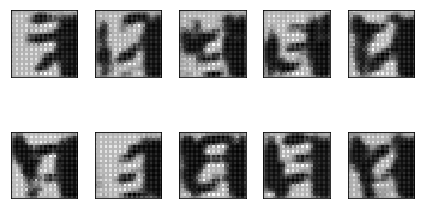

epoch = 2/100, d_loss=-0.093, g_loss=0.364                                                                                                                      
epoch = 3/100, d_loss=-0.019, g_loss=0.315                                                                                                                      
epoch = 4/100, d_loss=-0.008, g_loss=0.214                                                                                                                      
epoch = 5/100, d_loss=-0.022, g_loss=0.124                                                                                                                      
epoch = 6/100, d_loss=-0.002, g_loss=0.102                                                                                                                      
epoch = 7/100, d_loss=-0.000, g_loss=0.034                                                                                                                       
epoch = 8/100, d_loss=-0.004, g_l

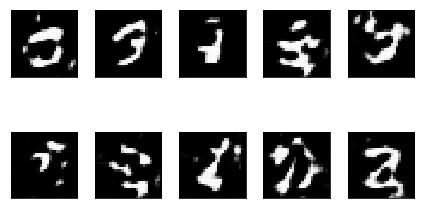

epoch = 12/100, d_loss=-0.016, g_loss=0.022                                                                                                                       
epoch = 13/100, d_loss=-0.012, g_loss=0.012                                                                                                                       
epoch = 14/100, d_loss=-0.011, g_loss=0.013                                                                                                                       
epoch = 15/100, d_loss=-0.013, g_loss=0.015                                                                                                                       
epoch = 16/100, d_loss=-0.014, g_loss=0.015                                                                                                                       
epoch = 17/100, d_loss=-0.016, g_loss=0.017                                                                                                                       
epoch = 18/100, d_loss

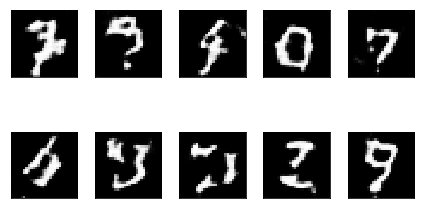

epoch = 22/100, d_loss=-0.013, g_loss=0.010                                                                                                                       
epoch = 23/100, d_loss=-0.011, g_loss=0.009                                                                                                                       
epoch = 24/100, d_loss=-0.013, g_loss=0.002                                                                                                                       
epoch = 25/100, d_loss=-0.014, g_loss=0.007                                                                                                                       
epoch = 26/100, d_loss=-0.019, g_loss=0.013                                                                                                                       
epoch = 27/100, d_loss=-0.011, g_loss=0.001                                                                                                                       
epoch = 28/100, d_loss

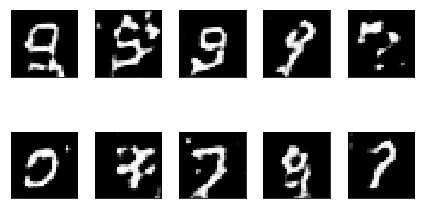

epoch = 32/100, d_loss=-0.013, g_loss=0.012                                                                                                                       
epoch = 33/100, d_loss=-0.017, g_loss=0.016                                                                                                                       
epoch = 34/100, d_loss=-0.012, g_loss=0.003                                                                                                                       
epoch = 35/100, d_loss=-0.015, g_loss=0.008                                                                                                                       
epoch = 36/100, d_loss=-0.014, g_loss=0.007                                                                                                                       
epoch = 37/100, d_loss=-0.017, g_loss=0.017                                                                                                                       
epoch = 38/100, d_loss

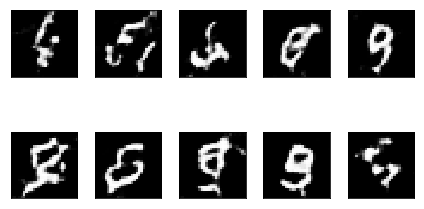

epoch = 42/100, d_loss=-0.014, g_loss=0.014                                                                                                                       
epoch = 43/100, d_loss=-0.012, g_loss=0.010                                                                                                                       
epoch = 44/100, d_loss=-0.014, g_loss=0.013                                                                                                                       
epoch = 45/100, d_loss=-0.009, g_loss=0.002                                                                                                                       
epoch = 46/100, d_loss=-0.005, g_loss=-0.004                                                                                                                      
epoch = 47/100, d_loss=-0.011, g_loss=0.007                                                                                                                       
epoch = 48/100, d_loss

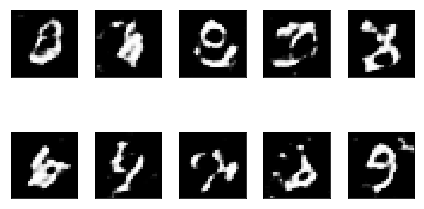

epoch = 52/100, d_loss=-0.011, g_loss=0.013                                                                                                                       
epoch = 53/100, d_loss=-0.012, g_loss=0.010                                                                                                                       
epoch = 54/100, d_loss=-0.008, g_loss=0.001                                                                                                                       
epoch = 55/100, d_loss=-0.008, g_loss=0.008                                                                                                                       
epoch = 56/100, d_loss=-0.009, g_loss=0.001                                                                                                                       
epoch = 57/100, d_loss=-0.009, g_loss=0.002                                                                                                                       
epoch = 58/100, d_loss

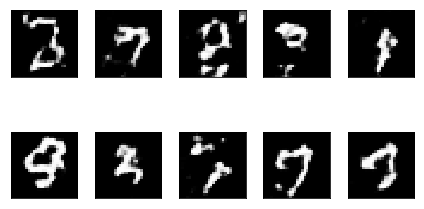

epoch = 62/100, d_loss=-0.011, g_loss=0.009                                                                                                                       
epoch = 63/100, d_loss=-0.011, g_loss=0.009                                                                                                                       
epoch = 64/100, d_loss=-0.009, g_loss=0.005                                                                                                                       
epoch = 65/100, d_loss=-0.008, g_loss=0.009                                                                                                                       
epoch = 66/100, d_loss=-0.006, g_loss=0.008                                                                                                                       
epoch = 67/100, d_loss=-0.011, g_loss=0.008                                                                                                                       
epoch = 68/100, d_loss

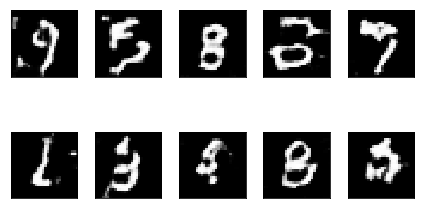

epoch = 72/100, d_loss=-0.006, g_loss=0.005                                                                                                                       
epoch = 73/100, d_loss=-0.013, g_loss=0.022                                                                                                                       
epoch = 74/100, d_loss=-0.002, g_loss=0.020                                                                                                                       
epoch = 75/100, d_loss=-0.001, g_loss=0.029                                                                                                                       
epoch = 76/100, d_loss=-0.001, g_loss=0.038                                                                                                                       
epoch = 77/100, d_loss=-0.008, g_loss=0.034                                                                                                                       
epoch = 78/100, d_loss

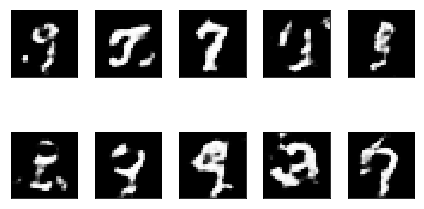

epoch = 82/100, d_loss=0.005, g_loss=0.034                                                                                                                        
epoch = 83/100, d_loss=0.003, g_loss=0.035                                                                                                                        
epoch = 84/100, d_loss=0.007, g_loss=0.037                                                                                                                        
epoch = 85/100, d_loss=0.008, g_loss=0.033                                                                                                                        
epoch = 86/100, d_loss=0.006, g_loss=0.034                                                                                                                        
epoch = 87/100, d_loss=0.007, g_loss=0.031                                                                                                                        
epoch = 88/100, d_loss

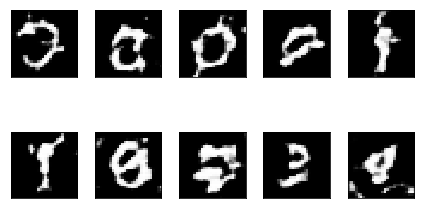

epoch = 92/100, d_loss=0.011, g_loss=0.038                                                                                                                        
epoch = 93/100, d_loss=0.009, g_loss=0.032                                                                                                                        
epoch = 94/100, d_loss=0.014, g_loss=0.039                                                                                                                        
epoch = 95/100, d_loss=0.013, g_loss=0.023                                                                                                                        
epoch = 96/100, d_loss=0.007, g_loss=0.036                                                                                                                        
epoch = 97/100, d_loss=0.016, g_loss=0.029                                                                                                                        
epoch = 98/100, d_loss

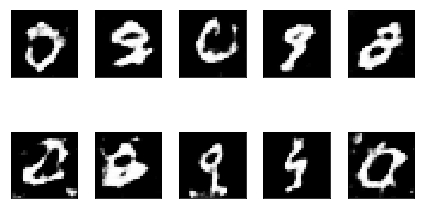

In [14]:
epochs = 100
batch_size = 64

real = -np.ones(shape=(batch_size, 1))
fake = np.ones(shape=(batch_size, 1))

d_loss = []
g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        for _ in range(n_critic):

            # Train Discriminator weights
            critic.trainable = True

            # Real samples
            X_batch = X_train[i*batch_size:(i+1)*batch_size]
            d_loss_real = critic.train_on_batch(x=X_batch, y=real)

            # Fake Samples
            z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
            X_fake = generator.predict(z)
            d_loss_fake = critic.train_on_batch(x=X_fake, y=fake)

            # Discriminator loss
            d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])

            # Clip critic weights
            for l in critic.layers:
                weights = l.get_weights()
                weights = [np.clip(w, -clip_value, clip_value) for w in weights]
                l.set_weights(weights)

        # Train Generator weights
        critic.trainable = False
        g_loss_batch = c_g.train_on_batch(x=z, y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

### 5. Evaluate model

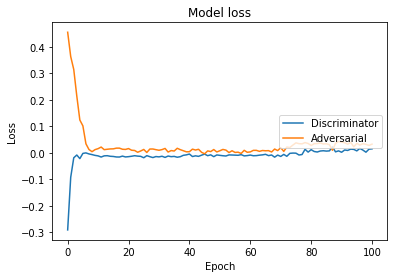

In [15]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

## References

* [GAN — Wasserstein GAN & WGAN-GP](https://medium.com/@jonathan_hui/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490)